In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [2]:
%cd 'My Drive/Forecasting'

/gdrive/My Drive/Forecasting


In [72]:
import torch
from torch.nn import GRU
import torchvision
import torchvision.transforms as transforms
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import sklearn
import matplotlib.pyplot as plt

In [7]:
%cd 'Dataset'
!ls

/gdrive/My Drive/Forecasting/Dataset
case_time_series.csv	 state_wise.csv
case_time_series.gsheet  state_wise_daily.csv


In [25]:
df = pd.read_csv('case_time_series.csv')
df.head()

,Date,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased
0,30 January,1,1,0,0,0,0
1,31 January,0,1,0,0,0,0
2,01 February,0,1,0,0,0,0
3,02 February,1,2,0,0,0,0
4,03 February,1,3,0,0,0,0


In [ ]:
# 0 -> 30 Jan
# 254 -> 10 Oct

In [64]:
df = df[['Daily Confirmed', 'Daily Recovered', 'Daily Deceased']]
sc = sklearn.preprocessing.MinMaxScaler()
data = sc.fit_transform(df.values)
data = pd.DataFrame(data)
data.shape

(255, 3)

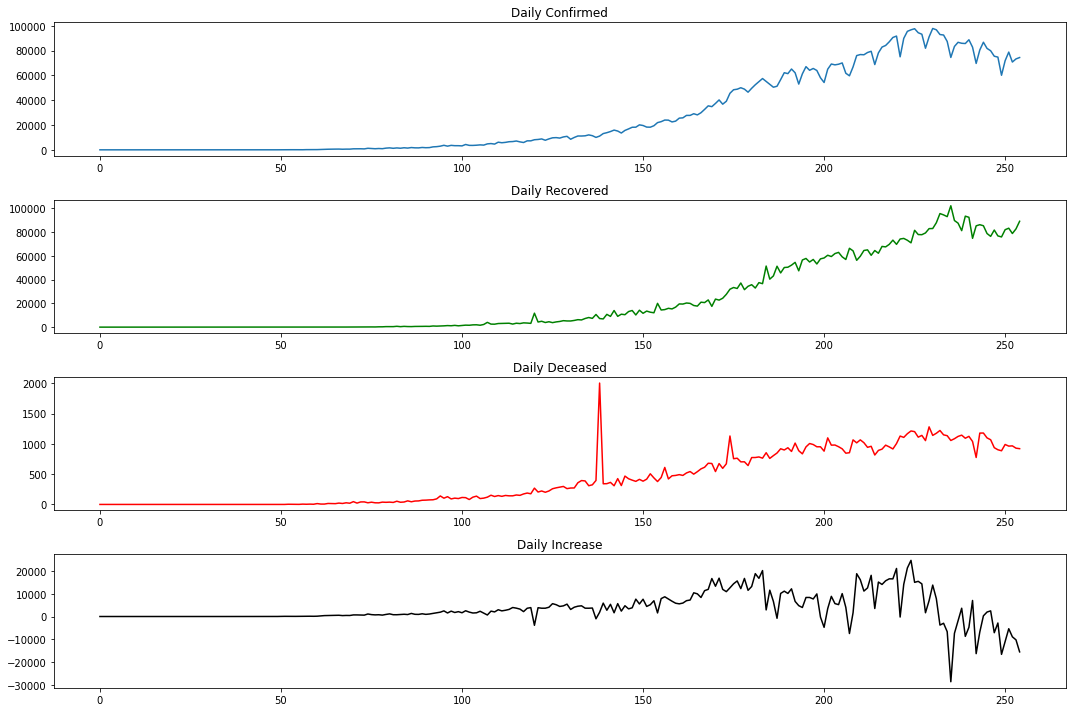

In [119]:
increase = df['Daily Confirmed'] - df['Daily Recovered'] - df['Daily Deceased']
fig,(a1, a2, a3, a4) = plt.subplots(nrows=4, ncols=1, figsize=(15, 10))
a1.plot(df['Daily Confirmed'])
a1.set_title('Daily Confirmed')
a2.plot(df['Daily Recovered'], color = 'green')
a2.set_title('Daily Recovered')
a3.plot(df['Daily Deceased'], color= 'red')
a3.set_title('Daily Deceased')
a4.plot(increase, color= 'black')
a4.set_title('Daily Increase')  # from this grapg we can infer that lately the number of increase in daily positive patients is going down (i.e no of people testing positive is less when compared to number of people getting recovered or deaths reported)
fig.tight_layout()

In [65]:
11#239 -> 25 sept

In [120]:
df_train = data[:240]
df_test = data[240:]

data_train = df_train[1:]
target_train = df_train[0]

data_train = data_train.to_numpy()
target_train = target_train.to_numpy()

data_test = df_test[1:]
target_test = df_test[0]

data_test = data_test.to_numpy()
target_test = target_test.to_numpy()

In [121]:
input_dim = 3
hidden_dim = 10
n_layers = 2
batch_size = 1

In [122]:
class GRUNet(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

In [ ]:
train_data = TensorDataset(torch.from_numpy(data_train), torch.from_numpy(target_train))
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last=False)

In [ ]:
def train(train_loader, learn_rate, hidden_dim=256, EPOCHS=5):
    
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]
    output_dim = 1
    n_layers = 2
    
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.clock()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            counter += 1
            if model_type == "GRU":
                h = h.data
            else:
                h = tuple([e.data for e in h])
            model.zero_grad()
            
            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            if counter%200 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.clock()
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
        print("Total Time Elapsed: {} seconds".format(str(current_time-start_time)))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model

def evaluate(model, test_x, test_y, label_scalers):
    model.eval()
    outputs = []
    targets = []
    start_time = time.clock()
    for i in test_x.keys():
        inp = torch.from_numpy(np.array(test_x[i]))
        labs = torch.from_numpy(np.array(test_y[i]))
        h = model.init_hidden(inp.shape[0])
        out, h = model(inp.to(device).float(), h)
        outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
        targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))
    print("Evaluation Time: {}".format(str(time.clock()-start_time)))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE